In [1]:
# These two lines allow for the notebook to automatically update to use the most
# up-to-date versions of the code being imported
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
import control as ct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyphotonicsims.control_systems.control_core import *
from pyphotonicsims.control_systems.calculate_laser_noise import *
from pyphotonicsims.laser_dynamics.brillouin_laser import *

# plt.style.available
%matplotlib inline
plt.style.use('science')
plt.rcParams['figure.figsize'] = [4,3]

## Stimulated Brillouin scattering (SBS) laser model is based on Ryan O. Behunin's paper.
#### Behunin, Ryan O., et al. "Fundamental noise dynamics in cascaded-order Brillouin lasers." Physical Review A 98.2 (2018): 023832.
#### Laser rate equations for SBS cascaded emission
$$\frac{da_m}{dt} = (i\Delta\omega - \gamma/2 + \mu(|a_{m-1}|^2 - |a_{m+1}|^2))a_m + \delta_{m0}i\sqrt(\gamma_{ex})F$$
#### Laser metrics caculation: cavity Q, threshold $P_{th}$, efficiency $\eta$, minimum ST linewidth $\nu_{ST}$
$$P_{th} = \frac{h\nu\gamma^3}{8\mu\gamma_{ex}} $$
$$\eta_{S1} = (\frac{\gamma_{ex}}{\gamma})^2$$
$$\nu_{ST,min} = \frac{n_0\gamma}{2\pi}$$

In [2]:
# 400 MQ
r = [0.9, 0.4]          # loss rates = [intrinsic, coupling] in MHz
L = 2*np.pi*11.787e-3   # cavity length in meter
vST_min = 0.3           # minimum S1 ST linewidth in Hz

# # 70 MQ
# r = [1.8, 1.8]
# L = 2*np.pi*11.787e-3
# vST_min = 0.7

# # 30 MQ OR3
# r = [3.5, 3.5]
# L = 2*np.pi*11.787e-3
# vST_min = 0.7

# # 30 MQ OR3
# r = [3.5, 3.5]
# L = 2*np.pi*11.787e-3
# vST_min = 0.7

# # 700MQ etched silica
# r = [3.5, 3.5]
# L = 2*np.pi*3e-3
# vST_min = 0.09

# # 700MQ TM at 1570
# r = [0.32, 0.056]
# L = 2*np.pi*11.787e-3
# vST_min = 0.15

# # double-ring 40nm TE SBS at 1550
# r = [0.8, 0.8]
# L = 2*np.pi*11.787e-3
# vST_min = 0.2

# # double-ring 80nm TM SBS at 1570
# r = [1.7, 1.2]
# L = 2*np.pi*11.787e-3
# vST_min = 0.5

# # 800MQ 4 meter fiber cavity at 1550
# r = [0.30, 0.40]
# L = 2*np.pi*11.787e-3
# vST_min = 0.007

# # 300MQ 4 meter coil
# r = [1.0, 1.0]
# L = 4.
# vST_min = 0.01

# # 100MQ 3mm radius SBS
# r = [3.0, 3.0]
# L = 2*np.pi*2.710e-3
# vST_min = 1.0

sbs = SBSLaser(ord = 4, r = r, L = L, vST_min = vST_min)

-----------------REPORT------------------
Cavity Q:      148.78 M
P_th:          1.065 mW
min FLW:       0.300 Hz
S1 efficiency: 0.095
rho:           6.289
GB:            0.094


#### Pump power sweep from 0 mW to $10\times P_{th}$, showing thresholding and linewidth narrowing behaviors 
- Power conversion: $P_{Si}$ Stokes power, $P_{disp}$ dissipated power due to cavity intrinsic loss
$$P_{pump, in} = P_{pump, out} + \sum_i P_{Si} + P_{disp}$$
- ST linewidth narrowing
$$\nu_{m,ST} = \frac{n_0(\gamma + 4\mu|a_{m+1}|^2)}{4\pi |a_m|^2}$$

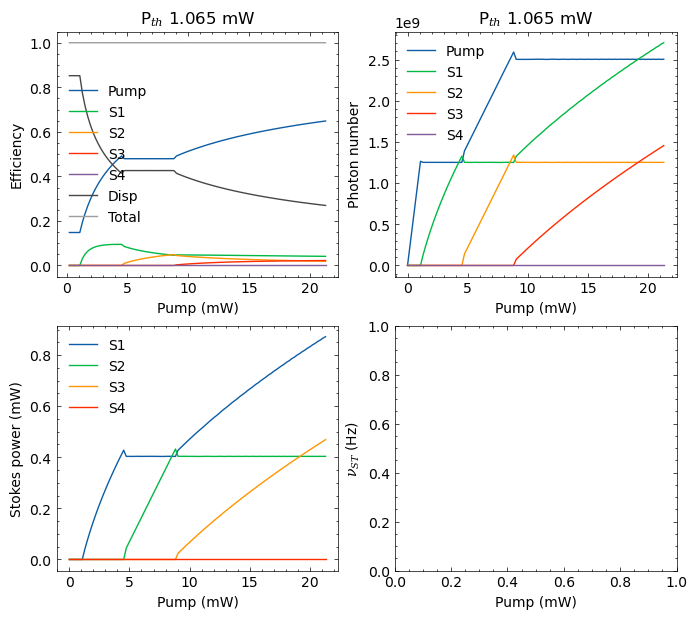

In [9]:
Px = np.linspace(0,20*sbs.P_th,100)
sbs.pump_sweep_visulization(Px)
# plt.savefig('sbs_laser_pump_sweep.png', dpi = 1000, bbox_inches = 'tight')

#### Pump laser detuning sweep below threshold

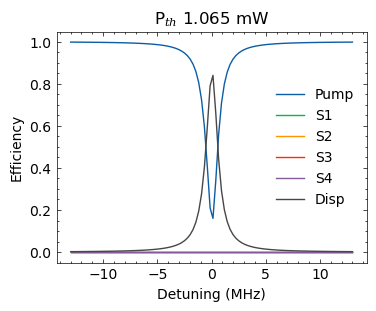

In [8]:
# abs_heating = [resoance heating redshift in MHz/mW, 
# absoption loss fraction in total intrinsic loss]
abs_heating = [1.0/(sbs.L/0.07), 0.1] 
dfx = np.linspace(-10, 10, 100)*sum(r)
sbs.detuning_sweep_visulization(dfx, 0.1*sbs.P_th, abs_heating)

#### Pump laser detuning sweep above threshold

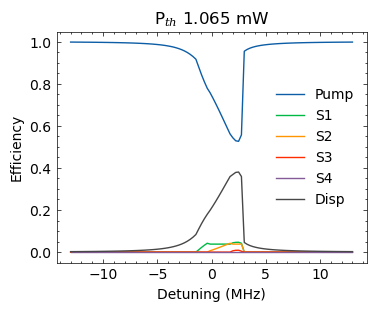

In [4]:
# abs_heating = [resoance heating redshift in MHz/mW, 
# absoption loss fraction in total intrinsic loss]
abs_heating = [1.0/(sbs.L/0.07), 0.1] 
dfx = np.linspace(-10, 10, 100)*sum(r)
sbs.detuning_sweep_visulization(dfx, 10*sbs.P_th, abs_heating)

## SBS phase/frequency matching plot
 - Integer multiple of resonator FSR, $N\Delta\nu_{FSR} = \frac{Nc}{n_g L}$, is almost a constant compared to the wavelength dependence of the SBS frequency shift, despite of very slight dispersion $n_g(\lambda)$ $$N\Delta\nu_{FSR} = \frac{Nc}{n_g L}$$
 - SBS frequency shift $$\Omega_B(\lambda) = \frac{2\pi n_g V_{ac}}{\lambda}$$
 - Wheather or not $N\Delta\nu_{FSR}$ is right on target of $\Omega_B(\lambda)$, a Brillouin gain can be estimated with a mismatch term $\Delta\Omega = N\Delta\nu_{FSR} - \Omega_B$, and $G_B(\Delta\Omega_B)$ peaks at $\Delta\Omega_B = 0$ or $N\Delta\nu_{FSR} = \Omega_B$
$$\lambda = \frac{2\pi n_g^2 V_{ac} L}{Nc}$$
 - Measured pump-S1 beatnote frequency $f_{p-S1}$ at the minimum threshold wavelength $\lambda_{match}$ indicate SBS phase matching, thus $\Delta\Omega_B = 0$ and $N\Delta\nu_{FSR} = \Omega_B = f_{p-S1}$
 
<img src="./figures/SBS_phase_matching.png" width="350"/> <img src="./figures/GB_spectrum.png" width="300"/>

Text(0, 0.5, 'G$_B$ (1/m W)')

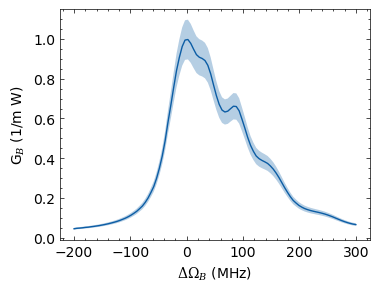

In [5]:
# SBS gain spectrum from COMSOL
df = pd.read_csv('data/SBS_gain_spectrum_comsol.csv')
df = df.values
dfx = np.linspace(-200.,300,100)
GBx = GB_spectrum_silica(dfx, ifinterp = True, df1 = df[:,0], GB1 = df[:,1])
plt.plot(dfx, GBx)
plt.fill_between(dfx, GBx*0.9, GBx*1.1, alpha = 0.3)
plt.xlabel(r'$\Delta\Omega_B$' + ' (MHz)')
plt.ylabel('G' + r'$_B$' + ' (1/m W)')

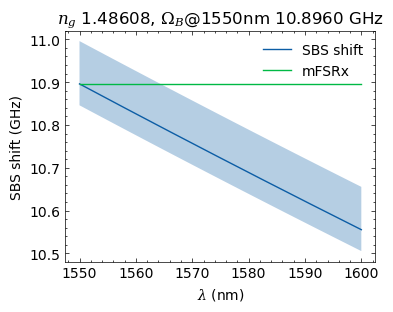

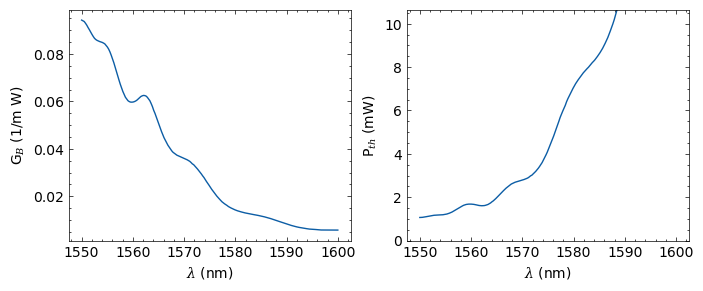

In [6]:
# 400 MQ 40nm thick nitride TE mode SBS resonator
# Measured pump-S1 beatnote frequency 10.8960 GHz at 1550 nm
f_pump_S1 = 10.8960e9
wl_match = 1550e-9
ng, Vac = sbs.get_ng_from_sbs_freq_matching(f_pump_S1, wl_match)
sbs.sbs_freq_matching_plot(ng, Vac, wl_match, m_plus = 0, ifinterp = True, df1 = df[:,0], GB1 = df[:,1])

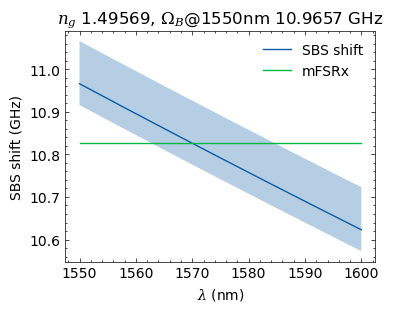

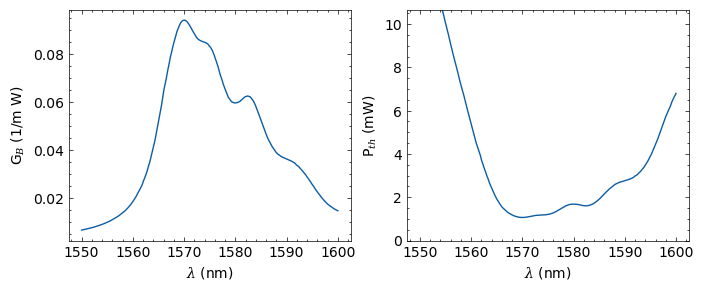

In [7]:
# 720 MQ 80nm thick nitride TM mode SBS resonator
# Measured pump-S1 beatnote frequency 10.8260 GHz at 1570 nm
f_pump_S1 = 10.8260e9
wl_match = 1570e-9
ng, Vac = sbs.get_ng_from_sbs_freq_matching(f_pump_S1, wl_match)
sbs.sbs_freq_matching_plot(ng, Vac, wl_match, m_plus = 0, ifinterp = True, df1 = df[:,0], GB1 = df[:,1])